In [1]:
import joblib
from mlchem.ml.modelling.model_interpretation import ShapExplainer
from mlchem.ml.preprocessing.scaling import scale_df_standard,transform_df
from mlchem.ml.preprocessing.feature_transformation import polynomial_expansion
from mlchem.helper import suppress_warnings
suppress_warnings()

from mlchem.ml.feature_selection.filters import collinearity_filter,diversity_filter

from mlchem.ml.modelling.model_interpretation import DescriptorExplainer
from mlchem.metrics import rmse_to_std_ratio
from sklearn.metrics import root_mean_squared_error
from mlchem.importables import interpretable_descriptors_rdkit
from sklearn.linear_model import LinearRegression

In [29]:
index = 2

best_estimators = ['KNN_3_COMB', 'KNN_9_COMB', 'LOGREG_l2_10_COMB']


estimator = joblib.load(f'../data/{best_estimators[index]}_estimator')
cols = joblib.load(f'../data/{best_estimators[index]}_cols')

train_set = joblib.load('../data/big_train_set_scaled')
test_set = joblib.load('../data/big_train_set_scaled')


y_train = joblib.load('../data/y_train')
y_test = joblib.load('../data/y_test')

print(estimator)

LogisticRegression(C=10, random_state=1, solver='liblinear')


# Shap Explainer

In [30]:
SX = ShapExplainer(estimator=estimator,
                   is_tree=False,
                   data=train_set[cols],
                   y=y_train)

### Explain?

In [31]:
SX.explain()

### Load?

In [21]:
shap_values = joblib.load(f'../data/shap_values_{best_estimators[index]}')
base_values = joblib.load(f'../data/base_values_{best_estimators[index]}')

SX.load(base_values,shap_values)

### Display

In [7]:
#SX.force_plot()

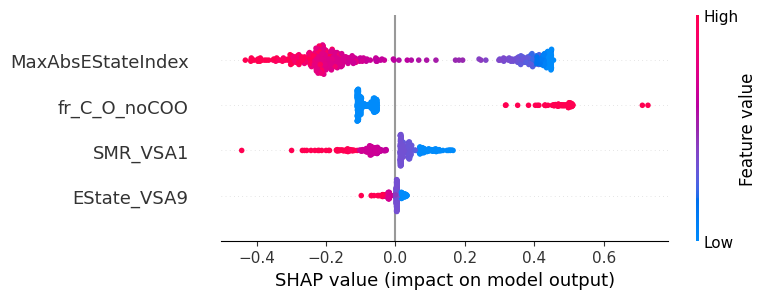

In [32]:
SX.summary_plot()

In [9]:
#SX.decision_plot(0,1)

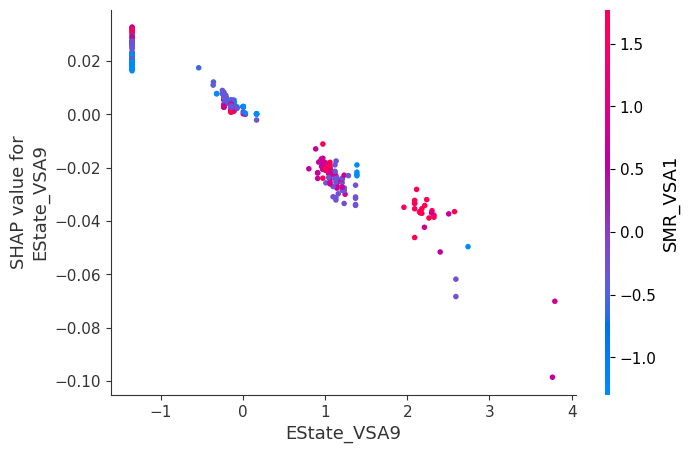

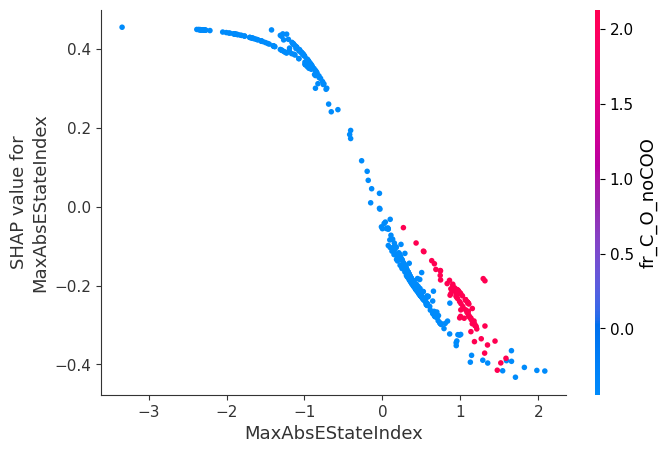

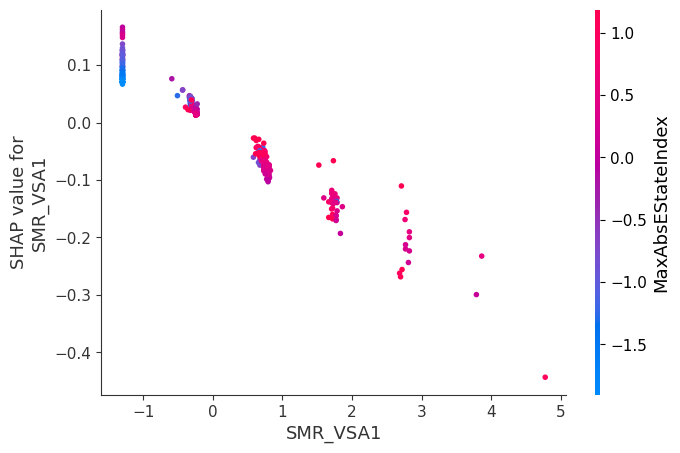

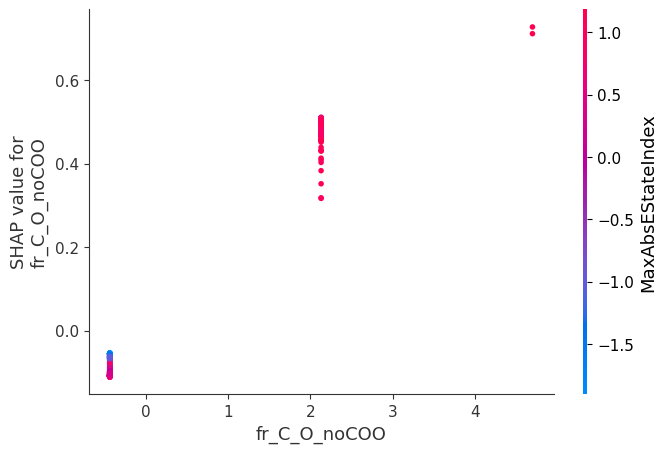

In [33]:
SX.dependence_plot_all()

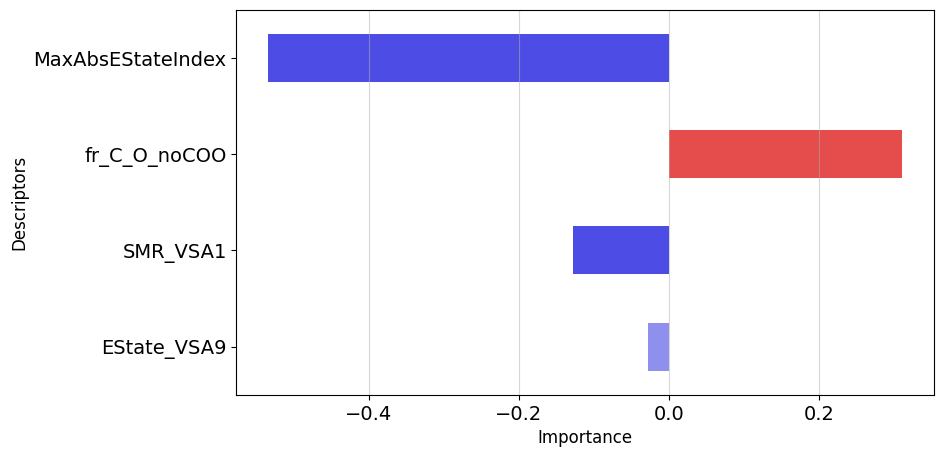

,W,correlation,overall_impact
MaxAbsEStateIndex,0.533691,-0.961067,-0.492944
fr_C_O_noCOO,0.310575,0.647928,0.130383
SMR_VSA1,0.127228,-0.973540,-0.120585
EState_VSA9,0.028505,-0.958796,-0.026205


In [80]:
SX.feature_importance()

In [34]:
joblib.dump(SX.shap_values,f'../data/shap_values_{best_estimators[index]}')
joblib.dump(SX.base_values,f'../data/base_values_{best_estimators[index]}')

['../data/base_values_LOGREG_l2_10_COMB']

# Descriptor interpretation

In [35]:
cols

['EState_VSA9', 'MaxAbsEStateIndex', 'SMR_VSA1', 'fr_C_O_noCOO']

In [36]:
train_set_original = joblib.load('../data/train_set_rdkit')
test_set_original = joblib.load('../data/test_set_rdkit')

In [148]:
interpretable_descriptors_rdkit

['MolWt',
 'HeavyAtomMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'HeavyAtomCount',
 'NHOHCount',
 'NOCount',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticHeterocycles',
 'NumAromaticRings',
 'NumHAcceptors',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRotatableBonds',
 'NumSaturatedCarbocycles',
 'NumSaturatedHeterocycles',
 'NumSaturatedRings',
 'RingCount',
 'MolLogP']

In [136]:
estimator = LinearRegression()

target_col = 'MaxAbsEStateIndex'

polynomial_degree = 3

collinearity_threshold = 0.7
diversity_threshold = 0.3

train_set_scaled = polynomial_expansion(train_set_original[interpretable_descriptors_rdkit],polynomial_degree)
test_set_scaled = polynomial_expansion(test_set_original[interpretable_descriptors_rdkit],polynomial_degree)

train_set_scaled,scaler = scale_df_standard(train_set_scaled,
                                            1)
test_set_scaled = transform_df(test_set_scaled,
                               scaler,
                               1)[0]

#train_set_scaled = train_set_scaled[interpretable_descriptors_rdkit]
#test_set_scaled = test_set_scaled[interpretable_descriptors_rdkit]

#train_set_scaled = polynomial_expansion(train_set_scaled,polynomial_degree)
#test_set_scaled = polynomial_expansion(test_set_scaled,polynomial_degree)


target_scaled_train,target_scaler = scale_df_standard(train_set_original[[target_col]],0)
target_scaled_test = transform_df(test_set_original[[target_col]],target_scaler,0)[0]

train_set_scaled = collinearity_filter(diversity_filter(train_set_scaled,diversity_threshold,None),collinearity_threshold,None)
test_set_scaled = test_set_scaled[train_set_scaled.columns]
print(train_set_scaled.shape)

(476, 28)


In [137]:
DX = DescriptorExplainer(df_train=train_set_scaled,df_test=test_set_scaled,target_train=target_scaled_train,
                         target_test=target_scaled_test,logic='smaller',estimator=estimator,metric=root_mean_squared_error)

In [138]:
target_scaled_train.std()

MaxAbsEStateIndex    1.001052
dtype: float64

In [143]:
DX.fit_stage_1(k=3,training_threshold=0.85,cv_train_ratio=0.7,cv_iter=5)

3682/3682 [==================================================]

In [144]:
DX.df_results_stage_1.head(10)

,feature_subsets,training_score,cv_score,test_score,geometric_mean
82,"[NOCount, NumAliphaticHeterocycles, NOCount^2 ...",0.804295,0.807205,0.911384,0.839525
124,"[NOCount, MolLogP, NHOHCount NOCount^2]",0.811359,0.817535,0.899208,0.841770
159,"[NOCount, MolWt NumAliphaticRings, NOCount^2 N...",0.809658,0.810517,0.912271,0.842809
131,"[NOCount, MolLogP, NumHAcceptors^3]",0.801742,0.805912,0.932053,0.844477
127,"[NOCount, MolLogP, NOCount^2 NumRotatableBonds]",0.811470,0.814570,0.912679,0.844967
118,"[NOCount, MolLogP, NOCount MolLogP]",0.818008,0.824368,0.894838,0.845034
277,"[NOCount, MolWt MolLogP^2, NOCount^2 NumRotata...",0.812167,0.812271,0.915138,0.845170
117,"[NOCount, MolLogP, NHOHCount MolLogP]",0.815045,0.822043,0.903302,0.845869
299,"[NOCount, NOCount^2 NumAliphaticRings, NOCount...",0.812126,0.813021,0.919455,0.846744
306,"[NOCount, NOCount^2 NumRotatableBonds, NumAlip...",0.812695,0.813212,0.918815,0.846811


In [145]:
DX.fit_stage_2(top_n_subsets=5,cv_iter=5)

119/119 [==================================================]

In [146]:
DX.df_results_stage_2.head(5)

,feature_subsets,training_score,cv_score,test_score,geometric_mean
12,"[MolLogP, NOCount, NOCount^2 NumRotatableBonds...",0.800800,0.808599,0.903752,0.836441
27,"[MolLogP, NHOHCount NOCount^2, NOCount, NOCoun...",0.793592,0.802228,0.919890,0.836650
24,"[MolLogP, MolWt NumAliphaticRings, NOCount, NO...",0.800610,0.810896,0.904027,0.837251
22,"[MolLogP, MolWt NumAliphaticRings, NHOHCount N...",0.806450,0.815381,0.895970,0.838321
10,"[MolLogP, NHOHCount NOCount^2, NOCount, NumAli...",0.809253,0.818097,0.890859,0.838621


Train R2: 0.36
Adj Train R2: 0.35
[('NOCount', 0.8), ('NOCount^2 NumRotatableBonds', -0.36), ('NumAliphaticHeterocycles', -0.14), ('MolLogP', -0.09)] intercept: 0.00
std_y: 1.00


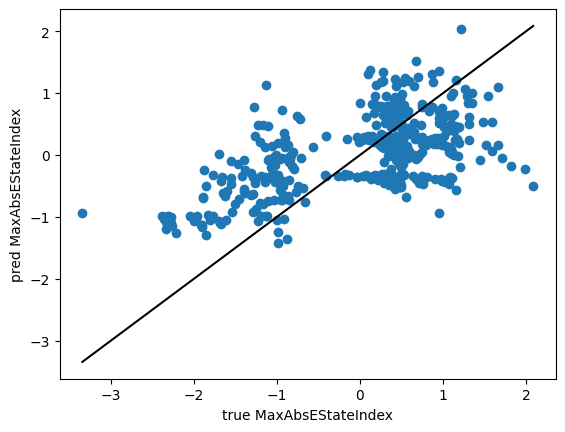

In [147]:
DX.display(0)